In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
sched = pd.read_csv('MatchStats6Year.csv')
sched.head()

,Date,Opponent,S,Kills,Errors,Total Attacks,Hit Pct,Assists,Aces,SErr,...,Block Solos,Block Assists,BErr,PTS,BHE,Team,Sets Won,Sets Lost,Match Result,Location
0,08/30/2019,UT Arlington,5,58,22,156,0.231,45,10,10,...,2,4,0,72.0,1,A&M-Corpus Christi,2,3,L,Neutral
1,08/30/2019,Houston,3,49,16,112,0.295,48,4,6,...,0,2,0,0.0,0,A&M-Corpus Christi,3,0,W,Neutral
2,08/31/2019,Arizona St.,4,46,17,147,0.197,37,2,5,...,1,0,0,49.0,3,A&M-Corpus Christi,1,3,L,Neutral
3,09/04/2019,UTRGV,5,61,26,167,0.210,57,6,9,...,4,6,0,74.0,2,A&M-Corpus Christi,2,3,L,Neutral
4,09/06/2019,New Mexico,3,48,12,104,0.346,41,2,7,...,0,6,0,53.0,0,A&M-Corpus Christi,3,0,W,Neutral


In [3]:
sched.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61139 entries, 0 to 61138
Data columns (total 22 columns):
Date             61139 non-null object
Opponent         61139 non-null object
S                61139 non-null int64
Kills            61139 non-null int64
Errors           61139 non-null int64
Total Attacks    61139 non-null int64
Hit Pct          61139 non-null float64
Assists          61139 non-null int64
Aces             61139 non-null int64
SErr             61139 non-null int64
Digs             61139 non-null int64
RErr             61139 non-null int64
Block Solos      61139 non-null int64
Block Assists    61139 non-null int64
BErr             61139 non-null int64
PTS              61139 non-null float64
BHE              61139 non-null int64
Team             61139 non-null object
Sets Won         61139 non-null int64
Sets Lost        61139 non-null int64
Match Result     61139 non-null object
Location         61139 non-null object
dtypes: float64(2), int64(15), object(5)
memor

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline

In [5]:
sched = sched.drop(['Assists'], axis=1)

In [32]:
labels = sched.loc[:,'S':'BHE'].columns.values
X = sched.loc[:,labels]

Y = (sched['Match Result'] == 'W').astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(45854, 14) (15285, 14) (45854,) (15285,)


In [33]:
from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

In [34]:
from sklearn.linear_model import LogisticRegression

logreg =  make_pipeline(QuantileTransformer(),
                        LogisticRegression(C=1e5))

logreg.fit(X_train, y_train)
print('LR score for training %.1f%%' % (logreg.score(X_train, y_train)*100))
print('LR score for test %.1f%%' % (logreg.score(X_test, y_test)*100))

LR score for training 86.8%
LR score for test 87.1%


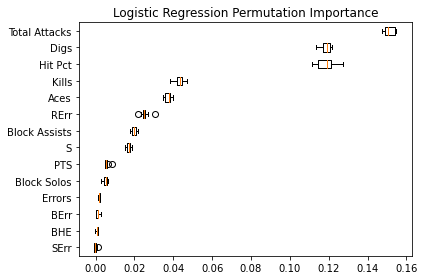

In [35]:
result = permutation_importance(logreg, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=labels[sorted_idx])
ax.set_title("Logistic Regression Permutation Importance")
fig.tight_layout()
plt.show()

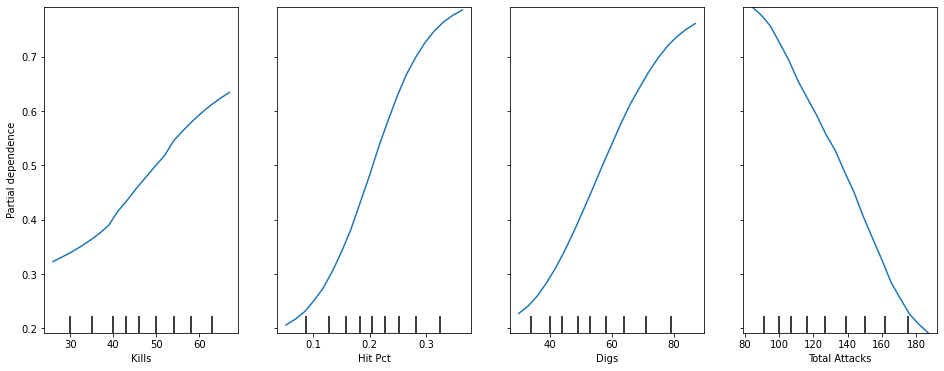

In [36]:
fig, ax = plt.subplots(figsize=(16,4))
plot_partial_dependence(logreg, X_train, labels[sorted_idx[-4:]],
                        n_jobs=3, grid_resolution=20, n_cols=4, ax=ax)

In [47]:
from sklearn.linear_model import SGDClassifier

svc = make_pipeline(QuantileTransformer(),
                    SGDClassifier(random_state = 0))

# fit model to training data
svc.fit(X_train, y_train)

print('SVM score for training %.1f%%' % (svc.score(X_train, y_train)*100))
print('SVM score for test %.1f%%' % (svc.score(X_test, y_test)*100))

SVM score for training 86.8%
SVM score for test 87.2%


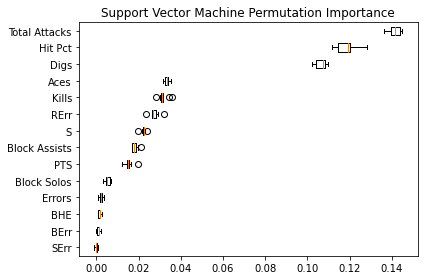

In [48]:
from sklearn.inspection import permutation_importance

result = permutation_importance(svc, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=3)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=labels[sorted_idx])
ax.set_title("Support Vector Machine Permutation Importance")
fig.tight_layout()
plt.show()

Text(0.5, 0.98, 'SVM Partial Dependence')

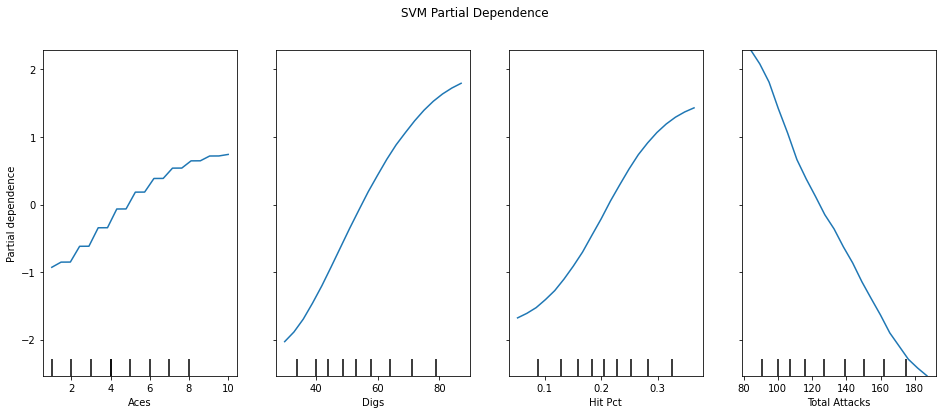

In [49]:
fig, ax = plt.subplots(figsize=(16,4))
plot_partial_dependence(svc, X_train, labels[sorted_idx[-4:]],
                        n_jobs=3, grid_resolution=20, n_cols=4, ax=ax)
fig.suptitle('SVM Partial Dependence')

In [37]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(max_iter=100).fit(X_train, y_train)

print('HGB score for training %.1f%%' % (hgb.score(X_train, y_train)*100))
print('HGB score for test %.1f%%' % (hgb.score(X_test, y_test)*100))

HGB score for training 88.9%
HGB score for test 87.0%


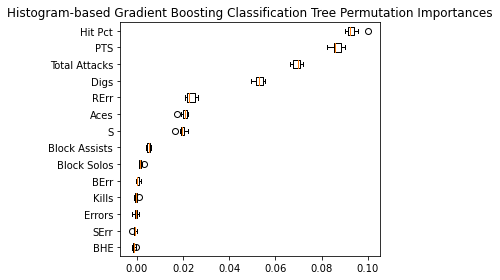

In [38]:
result = permutation_importance(hgb, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=labels[sorted_idx])
ax.set_title("Histogram-based Gradient Boosting Classification Tree Permutation Importances")
fig.tight_layout()
plt.show()

Text(0.5, 0.98, 'HGB Partial Dependence')

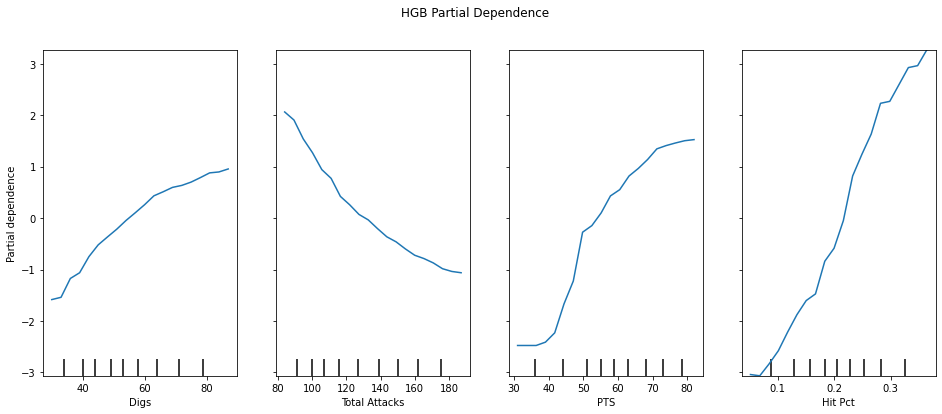

In [39]:
fig, ax = plt.subplots(figsize=(16,4))
plot_partial_dependence(hgb, X_train, labels[sorted_idx[-4:]],
                        n_jobs=3, grid_resolution=20, n_cols=4, ax=ax)
fig.suptitle('HGB Partial Dependence')

In [86]:
from sklearn.neural_network import MLPClassifier

mlc = make_pipeline(QuantileTransformer(),
                    MLPClassifier(hidden_layer_sizes=(100, 75),
                    learning_rate_init=0.001,
                    early_stopping=True)).fit(X_train, y_train)

print('MLP score for training %.1f%%' % (mlc.score(X_train, y_train)*100))
print('MLP score for test %.1f%%' % (mlc.score(X_test, y_test)*100))

MLP score for training 87.2%
MLP score for test 87.2%


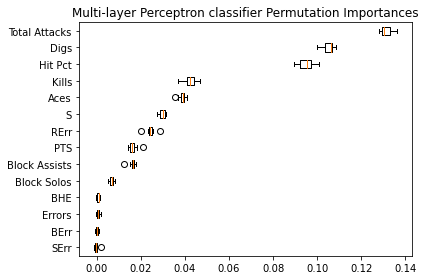

In [85]:
result = permutation_importance(mlc, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=labels[sorted_idx])
ax.set_title("Multi-layer Perceptron classifier Permutation Importances")
fig.tight_layout()
plt.show()

Text(0.5, 0.98, 'MLC Partial Dependence')

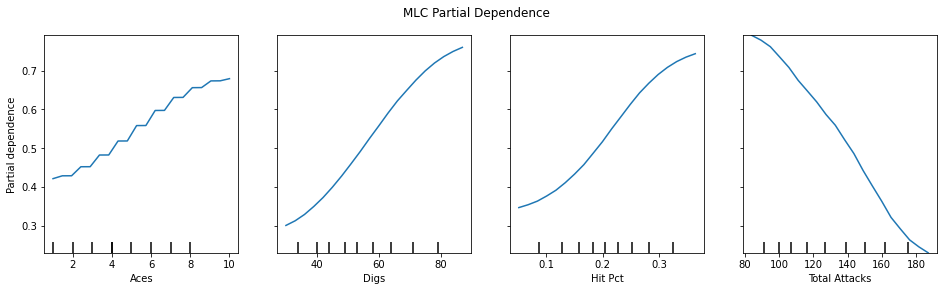

In [82]:
fig, ax = plt.subplots(figsize=(16,4))
plot_partial_dependence(mlc, X_train, labels[sorted_idx[-4:]],
                        n_jobs=3, grid_resolution=20, n_cols=4, ax=ax)
fig.suptitle('MLC Partial Dependence')

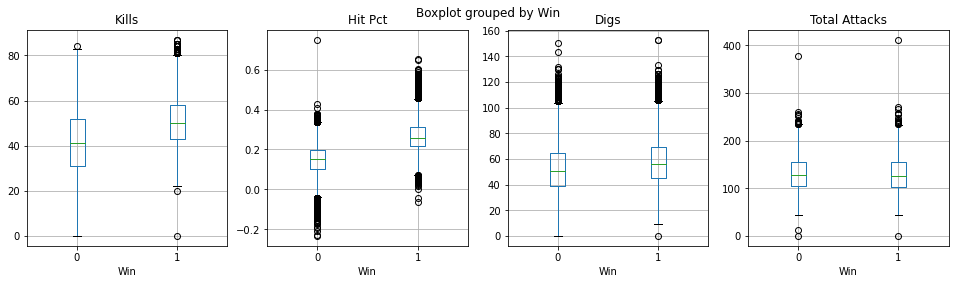

In [81]:
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(16,4))
sched.boxplot('Kills', by='Win', ax=ax[0])
sched.boxplot('Hit Pct', by='Win', ax=ax[1])
sched.boxplot('Digs', by='Win', ax=ax[2])
_ = sched.boxplot('Total Attacks', by='Win', ax=ax[3])

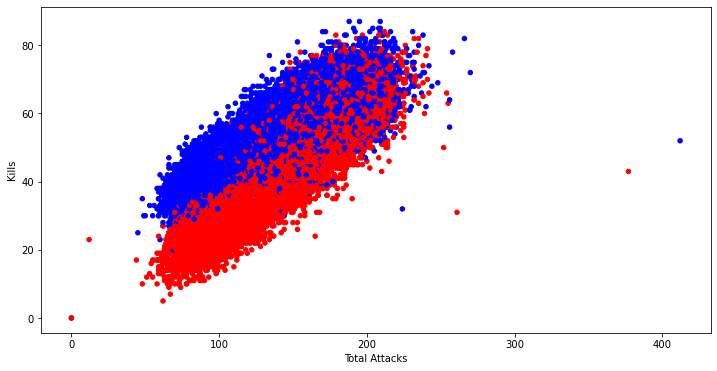

In [83]:
fig, ax = plt.subplots(figsize=(12,6))
colors = {0:'red', 1:'blue'}
sched.plot(kind='scatter',
           x='Total Attacks',
           y='Kills', 
           c=sched['Win'].apply(lambda x: colors[x]),
           ax=ax)